In [201]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [202]:
def step(t, dt):
    t = t + dt
    return t

In [203]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            
#                     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#                     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

In [204]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [205]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below

#         if self.view_max > end_row:
#             self.view_max = end_row + self.width / 2
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [206]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [238]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n, max_vel, max_accel):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time
        
#         can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # akes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
    
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
                    
            elif self.unloadFlag == 1: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)

        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
#         # stop the arm from moving below the bottom of the frame
        if self.q_a[2] < self.q_f[2] - self.height_f / 2:
            self.q_a[2] = self.q_f[2] - self.height_f / 2
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         print("").ocation: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
                
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
#                 print("DOES IT UNLOAD?")
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
                
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop of fthe fruit or fruit cannot be reached
                self.tx         = 0.
                self.free       = 1 
                self.x_move     = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                # reset the unloading flag 
                self.unloadFlag = 0
                        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        
        self.trapTimes()
            
        # maybe start time here? => evaluate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [239]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [240]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row (when the mid-point of vehicle reaches this point it stops)
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [241]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.005])   # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

qv0 = []
qv1 = []

In [242]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [243]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [244]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

max_v = 1.
max_a = 10.

arm_offset = 0.75 / (num_row_arms-1) # divide by num of arms because it's going to be inverted diagonal vs row num

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        # fruit's in a diagonal, so get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_a[0] + 0.3 + ((num_row_arms-1)*arm_offset - arm_offset*rows)  
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows, max_v, max_a)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [245]:
## start timer to see how long code takes to execute
start_time = time.time()

# should_reach = 0

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)                     
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 7.35 9.8678696059 0.0
start, end, start velocity: 6.0 5.3231695488 0.0
start, end, start velocity: 1.5 1.1919865482 0.0
start, end, start velocity: 7.35 9.9191284757 0.0
start, end, start velocity: 9.0 7.5732524703 0.0
start, end, start velocity: 1.5 1.4549112491 0.0
start, end, start velocity: 7.35 9.0836432909 0.0
start, end, start velocity: 12.0 10.794768294 0.0
start, end, start velocity: 1.5 0.9577824011 0.0
start, end, start velocity: 6.975 7.8880462924 0.0
start, end, start velocity: 6.0 5.9278863172 0.0
start, end, start velocity: 4.5 4.2075675354 0.0
start, end, start velocity: 6.975 8.2155859972 0.0
start, end, start velocity: 9.0 7.5099152899 0.0
start, end, start velocity: 4.5 3.7314053709 0.0
start, end, start velocity: 6.975 7.7962720949 0.0
start, end, start velocity: 12.0 10.5610279055 0.0
start, end, start velocity: 4.5 4.0949260327 0.0
start, end, start velocity: 6.6 7.5979936552 0.0
start, end, start velocity: 6.0 6.0434705216 0.0
start, e

start, end, start velocity: 8.859016812699734 7.35 0
start, end, start velocity: 6.600000000000042 7.2338394574 0.0
start, end, start velocity: 6.394462262645969 6.4173213786 0.0
start, end, start velocity: 6.000000000000423 8.1098297497 0.0
start, end, start velocity: 7.35000000000017 8.5112964451 0.0
start, end, start velocity: 11.131203271000013 11.225894179 0.0
start, end, start velocity: 4.0230243181921255e-13 2.6594242893 0.0
start, end, start velocity: 7.856908574699844 6.975 0
start, end, start velocity: 9.802261441599567 7.35 0
start, end, start velocity: 7.4161710571999215 6.975 0
start, end, start velocity: 1.398721494999782 0.0 0.0
start, end, start velocity: 5.5091652498995565 3.0 0.0
start, end, start velocity: 4.41256374729975 3.0 0.0
start, end, start velocity: 7.888532203299773 6.6 0
start, end, start velocity: 7.350000000000266 9.0814318178 0.0
start, end, start velocity: 5.576852206752538 5.5834833471 0.0
start, end, start velocity: 2.1779680923345035e-13 2.295372373

start, end, start velocity: 8.835538401600333 6.975 0
start, end, start velocity: 7.10110256480009 6.6 0
start, end, start velocity: 7.35 8.4445107683 0.0
start, end, start velocity: 11.441077010906039 11.4653766382 0.0
start, end, start velocity: 0.0 2.2924537171 0.0
start, end, start velocity: 7.034962667000185 6.0 0.0
start, end, start velocity: 3.5557173289000996 3.0 0.0
start, end, start velocity: 9.793405035900436 7.35 0
start, end, start velocity: 7.7438947854002045 6.6 0
start, end, start velocity: 6.975 8.4164338821 0.0
start, end, start velocity: 11.130263813600092 11.267316874 0.0
start, end, start velocity: 3.0 3.2419527195 0.0
start, end, start velocity: 7.886888742000163 6.975 0
start, end, start velocity: 6.6 6.9357649548 0.0
start, end, start velocity: 7.404854505556466 7.4376066872 0.0
start, end, start velocity: 6.0 7.3155241482 0.0
start, end, start velocity: 9.733848072900427 7.35 0
start, end, start velocity: 8.46489372260044 6.0 0.0
start, end, start velocity: 5.5

start, end, start velocity: 8.398262673698724 6.0 0.0
start, end, start velocity: 6.9750000000004295 7.9787818672 0.0
start, end, start velocity: 6.560479631905681 6.5908828508 0.0
start, end, start velocity: 3.000000000000984 5.052131775 0.0
start, end, start velocity: 9.766366115298712 7.35 0
start, end, start velocity: 7.3500000000008665 9.1698792312 0.0
start, end, start velocity: 11.532756490186985 11.5526705688 0.0
start, end, start velocity: 1.0011621523128844e-12 1.4531402558 0.0
start, end, start velocity: 6.600000000000563 7.7224076075 0.0
start, end, start velocity: 12.117599884808913 12.1272206276 0.0
start, end, start velocity: 6.0000000000009255 7.1395436973 0.0
start, end, start velocity: 6.975000000000424 7.5768229295 0.0
start, end, start velocity: 11.412538624809363 11.4622129926 0.0
start, end, start velocity: 3.0000000000012186 5.6297854681 0.0
start, end, start velocity: 9.776153542498708 7.35 0
start, end, start velocity: 6.60000000000028 7.8295702542 0.0
start, e

start, end, start velocity: 6.6000000000004135 7.6944416079 0.0
start, end, start velocity: 12.269093531835011 12.2727542115 0.0
start, end, start velocity: 6.000000000000808 7.2351406646 0.0
start, end, start velocity: 6.600000000000206 7.0680172633 0.0
start, end, start velocity: 7.782294541262832 7.7922334342 0.0
start, end, start velocity: 6.000000000001373 8.5754345918 0.0
start, end, start velocity: 7.350000000001138 8.9552660833 0.0
start, end, start velocity: 5.997235125594781 6.0769048174 0.0
start, end, start velocity: 5.874909391433147e-13 0.5534953153 0.0
start, end, start velocity: 7.5264664521997044 6.975 0
start, end, start velocity: 8.977494767999133 7.35 0
start, end, start velocity: 9.333058668998941 7.35 0
start, end, start velocity: 6.975000000000366 8.0256547424 0.0
start, end, start velocity: 11.57245445362872 11.5906075966 0.0
start, end, start velocity: 3.000000000001325 5.7437268997 0.0
start, end, start velocity: 5.465470256698685 3.0 0.0
start, end, start vel

start, end, start velocity: 7.382584600901227 6.0 0.0
start, end, start velocity: 3.3078853615002686 3.0 0.0
start, end, start velocity: 2.865475675502585 0.0 0.0
start, end, start velocity: 7.35 8.4523149408 0.0
start, end, start velocity: 11.642992312650488 11.6668870265 0.0
start, end, start velocity: 0.0 2.6346761271 0.0
start, end, start velocity: 6.975 7.5678604556 0.0
start, end, start velocity: 7.010205511460332 7.1296137397 0.0
start, end, start velocity: 3.0 4.8486375063 0.0
start, end, start velocity: 6.89152898690026 6.6 0
start, end, start velocity: 8.959074252602624 6.0 0.0
start, end, start velocity: 7.35 8.753620466 0.0
start, end, start velocity: 6.230505692260642 6.2580766609 0.0
start, end, start velocity: 0.0 2.5997282801 0.0
start, end, start velocity: 6.6 7.1475465094 0.0
start, end, start velocity: 12.426668473135003 12.4857757745 0.0
start, end, start velocity: 6.0 6.9892187133 0.0
start, end, start velocity: 8.001465956500908 6.975 0
start, end, start velocity:

start, end, start velocity: 8.576741701302284 6.0 0.0
start, end, start velocity: 7.920877157600836 6.975 0
start, end, start velocity: 6.6 7.2025274 0.0
start, end, start velocity: 12.68680149907113 12.6993695422 0.0
start, end, start velocity: 6.0 8.5572339296 0.0
start, end, start velocity: 8.45074300510098 7.35 0
start, end, start velocity: 7.35 9.0876962818 0.0
start, end, start velocity: 6.384423832207446 6.433470139 0.0
start, end, start velocity: 0.0 2.7916518632 0.0
start, end, start velocity: 3.2540050919002237 3.0 0.0
start, end, start velocity: 6.975 7.7539153434 0.0
start, end, start velocity: 7.308098503282749 7.3423548323 0.0
start, end, start velocity: 3.0 3.6997952061 0.0
start, end, start velocity: 7.36068964410034 6.975 0
start, end, start velocity: 6.6 6.6801852233 0.0
start, end, start velocity: 8.12868674109293 8.1482866253 0.0
start, end, start velocity: 6.0 6.8645802345 0.0
start, end, start velocity: 1.2634839646011466 0.0 0.0
start, end, start velocity: 9.0929

start, end, start velocity: 7.405416173100713 6.6 0
start, end, start velocity: 7.082820708900428 6.6 0
start, end, start velocity: 8.613583317802322 6.0 0.0
start, end, start velocity: 7.35 8.9260890299 0.0
start, end, start velocity: 11.771838369694423 11.7837420458 0.0
start, end, start velocity: 0.0 0.7719053887 0.0
start, end, start velocity: 8.515435209002232 6.0 0.0
start, end, start velocity: 3.514848165700455 3.0 0.0
start, end, start velocity: 2.8589673487025764 0.0 0.0
start, end, start velocity: 9.819376141502188 7.35 0
start, end, start velocity: 6.975 8.1398842161 0.0
start, end, start velocity: 7.825937186800107 7.8724415143 0.0
start, end, start velocity: 3.0 4.6588623813 0.0
start, end, start velocity: 7.8448499132007665 6.975 0
start, end, start velocity: 5.165021786901921 3.0 0.0
start, end, start velocity: 6.6 6.8391287341 0.0
start, end, start velocity: 8.210818363215337 8.2395500063 0.0
start, end, start velocity: 6.0 6.4070851287 0.0
start, end, start velocity: 8

start, end, start velocity: 9.286099468901718 7.35 0
start, end, start velocity: 2.302624616502088 0.0 0.0
start, end, start velocity: 6.6 6.4020236348 0.0
start, end, start velocity: 8.452498521217636 8.4912861171 0.0
start, end, start velocity: 6.0 8.0625047241 0.0
start, end, start velocity: 4.855233879001645 3.0 0.0
start, end, start velocity: 6.6 7.5296601035 0.0
start, end, start velocity: 13.040214232640961 13.1960050952 0.0
start, end, start velocity: 6.0 7.700774167 0.0
start, end, start velocity: 7.852242141000774 6.975 0
start, end, start velocity: 8.384471836800916 7.35 0
start, end, start velocity: 4.6443445353014585 3.0 0.0
start, end, start velocity: 2.7825132663025145 0.0 0.0
start, end, start velocity: 0.8227683960007462 0.0 0.0
start, end, start velocity: 6.975 8.8883629493 0.0
start, end, start velocity: 8.070708325300568 8.0722593184 0.0
start, end, start velocity: 3.0 3.8445091714 0.0
start, end, start velocity: 7.35 8.4168977659 0.0
start, end, start velocity: 11.

start, end, start velocity: 8.823509589401636 6.975 0
start, end, start velocity: 8.321904667101192 6.975 0
start, end, start velocity: 1.6919217895015382 0.0 0.0
start, end, start velocity: 1.663264188201511 0.0 0.0
start, end, start velocity: 7.35 9.6417122426 0.0
start, end, start velocity: 6.826467719452006 6.8357736574 0.0
start, end, start velocity: 0.0 2.3050511045 0.0
start, end, start velocity: 6.6 7.1513617857 0.0
start, end, start velocity: 13.340620738351168 13.4213338132 0.0
start, end, start velocity: 6.0 6.2999504539 0.0
start, end, start velocity: 4.102811743100979 3.0 0.0
start, end, start velocity: 6.924678552100286 6.6 0
start, end, start velocity: 4.189192564901051 3.0 0.0
start, end, start velocity: 7.35 8.4126490966 0.0
start, end, start velocity: 9.596201780814859 9.6194193342 0.0
start, end, start velocity: 0.0 2.0720212784 0.0
start, end, start velocity: 7.35 8.524560153 0.0
start, end, start velocity: 12.159671166411217 12.1671362794 0.0
start, end, start velo

start, end, start velocity: 7.202805312500198 6.975 0
start, end, start velocity: 5.831373702302516 3.0 0.0
start, end, start velocity: 8.53297000880105 7.35 0
start, end, start velocity: 7.326388108500641 6.6 0
start, end, start velocity: 7.534831440200827 6.6 0
start, end, start velocity: 9.727568840702109 7.35 0
start, end, start velocity: 9.033616125401824 6.975 0
start, end, start velocity: 8.220327565801973 6.0 0.0
start, end, start velocity: 2.0662982937018746 0.0 0.0
start, end, start velocity: 6.3448542481003045 6.0 0.0
start, end, start velocity: 6.6 7.6536451527 0.0
start, end, start velocity: 8.82015054639165 8.8352068058 0.0
start, end, start velocity: 6.0 7.7034804995 0.0
start, end, start velocity: 6.975 7.1958541826 0.0
start, end, start velocity: 12.41893321632281 12.4201858827 0.0
start, end, start velocity: 3.0 5.8516380306 0.0
start, end, start velocity: 9.023932013001485 7.35 0
start, end, start velocity: 3.037982875856544 3.0 0.0
start, end, start velocity: 0.8374

start, end, start velocity: 6.975 8.4223609307 0.0
start, end, start velocity: 8.399939121052533 8.4142997855 0.0
start, end, start velocity: 3.0 3.7874451806 0.0
start, end, start velocity: 0.8330032491007554 0.0 0.0
start, end, start velocity: 6.6 7.3427532135 0.0
start, end, start velocity: 13.732265454767138 13.7445399316 0.0
start, end, start velocity: 6.0 8.2514666603 0.0
start, end, start velocity: 6.6 6.9126566351 0.0
start, end, start velocity: 8.992966139487132 9.1412896199 0.0
start, end, start velocity: 6.0 6.6364401797 0.0
start, end, start velocity: 2.2189137857020076 0.0 0.0
start, end, start velocity: 5.3095355525020445 3.0 0.0
start, end, start velocity: 7.35 9.3159587373 0.0
start, end, start velocity: 12.452805034779406 12.6000374755 0.0
start, end, start velocity: 0.0 0.8726229114 0.0
start, end, start velocity: 6.912656635100278 6.6 0
start, end, start velocity: 8.422360930701283 6.975 0
start, end, start velocity: 6.636440179700562 6.0 0.0
start, end, start veloci

start, end, start velocity: 7.34053978480066 6.6 0
start, end, start velocity: 6.975 8.5230697552 0.0
start, end, start velocity: 12.79630975912513 12.821220964 0.0
start, end, start velocity: 3.0 4.4740975821 0.0
start, end, start velocity: 0.6529994689005917 0.0 0.0
start, end, start velocity: 6.539543862300473 6.0 0.0
start, end, start velocity: 7.411663115500721 6.6 0
start, end, start velocity: 8.506398351201025 7.35 0
start, end, start velocity: 6.6 7.1187491971 0.0
start, end, start velocity: 9.327556025916685 9.3871786596 0.0
start, end, start velocity: 6.0 6.4928662589 0.0
start, end, start velocity: 6.975 8.0151685485 0.0
start, end, start velocity: 8.532798197262476 8.5566864005 0.0
start, end, start velocity: 3.0 5.2130979249 0.0
start, end, start velocity: 7.35 9.6201874872 0.0
start, end, start velocity: 7.093395916391096 7.2385651516 0.0
start, end, start velocity: 0.0 2.2981359016 0.0
start, end, start velocity: 8.105453611001867 6.0 0.0
start, end, start velocity: 1.56

start, end, start velocity: 2.4894409106022475 0.0 0.0
start, end, start velocity: 9.730187565402117 7.35 0
start, end, start velocity: 6.6 7.3081611484 0.0
start, end, start velocity: 14.32610056070033 14.3300198869 0.0
start, end, start velocity: 6.0 7.5359090284 0.0
start, end, start velocity: 6.975 8.5941126744 0.0
start, end, start velocity: 8.619818762492168 8.6275245988 0.0
start, end, start velocity: 3.0 3.4717857262 0.0
start, end, start velocity: 8.60868643290145 6.975 0
start, end, start velocity: 7.125888762100464 6.6 0
start, end, start velocity: 8.014490099201788 6.0 0.0
start, end, start velocity: 8.676355134601176 7.35 0
start, end, start velocity: 7.35 8.7817253241 0.0
start, end, start velocity: 12.96647833280016 12.9905328283 0.0
start, end, start velocity: 0.0 2.4091096163 0.0
start, end, start velocity: 2.46700296820223 0.0 0.0
start, end, start velocity: 4.00206626400089 3.0 0.0
start, end, start velocity: 7.3081611484006235 6.6 0
start, end, start velocity: 8.594

start, end, start velocity: 6.238818801900207 6.0 0.0
start, end, start velocity: 6.600014297598833 7.2990478639 0.0
start, end, start velocity: 14.436713181194657 14.4977907286 0.0
start, end, start velocity: 6.0 6.9414179769 0.0
start, end, start velocity: 7.572722380100526 6.975 0
start, end, start velocity: 6.6 7.6606646089 0.0
start, end, start velocity: 10.196646534326005 10.2713533588 0.0
start, end, start velocity: 6.0 6.141282947 0.0
start, end, start velocity: 5.053731682601823 3.0 0.0
start, end, start velocity: 6.975 8.7878274632 0.0
start, end, start velocity: 8.769966066411895 8.8226369836 0.0
start, end, start velocity: 3.0 4.3690321429 0.0
start, end, start velocity: 7.6606646089009445 6.6 0
start, end, start velocity: 7.299047863900616 6.6 0
start, end, start velocity: 8.255765849300802 7.35 0
start, end, start velocity: 6.941417976900837 6.0 0.0
start, end, start velocity: 6.141282947000127 6.0 0.0
start, end, start velocity: 6.975 8.4923131943 0.0
start, end, start v

start, end, start velocity: 7.227364742300553 6.6 0
start, end, start velocity: 4.967455317601743 3.0 0.0
start, end, start velocity: 6.979761818200863 6.0 0.0
start, end, start velocity: 2.1244005904019283 0.0 0.0
start, end, start velocity: 6.6 8.0757184529 0.0
start, end, start velocity: 14.665809461065125 14.6696042984 0.0
start, end, start velocity: 6.0 6.8076926836 0.0
start, end, start velocity: 7.35 8.8156435908 0.0
start, end, start velocity: 13.60348435112424 13.6359592262 0.0
start, end, start velocity: 1.2878485920003278 1.3327042018 0.0
start, end, start velocity: 6.975 7.4735877283 0.0
start, end, start velocity: 13.211277411678132 13.2167203538 0.0
start, end, start velocity: 3.0 5.9304104053 0.0
start, end, start velocity: 8.16275969730105 6.975 0
start, end, start velocity: 8.24064359080136 7.35 0
start, end, start velocity: 7.35 9.2616997983 0.0
start, end, start velocity: 13.632974235395459 13.6643466823 0.0
start, end, start velocity: 0.0 2.2710677576 0.0
start, end

start, end, start velocity: 7.819332960601077 6.6 0
start, end, start velocity: 1.2353249147011196 0.0 0.0
start, end, start velocity: 6.975 8.0019375998 0.0
start, end, start velocity: 9.389512395141114 9.4496101232 0.0
start, end, start velocity: 3.0 4.9133399304 0.0
start, end, start velocity: 8.533645027501379 6.975 0
start, end, start velocity: 8.053559709201823 6.0 0.0
start, end, start velocity: 7.35 9.1750712496 0.0
start, end, start velocity: 13.844208851698331 13.8560980534 0.0
start, end, start velocity: 0.0 1.2490554474 0.0
start, end, start velocity: 3.9754789308989946 3.0 0.0
start, end, start velocity: 8.001937599800907 6.975 0
start, end, start velocity: 6.6 7.1206817487 0.0
start, end, start velocity: 14.814193976924841 14.8250732416 0.0
start, end, start velocity: 6.0 7.1134866108 0.0
start, end, start velocity: 6.975 9.0275781278 0.0
start, end, start velocity: 13.34949727286957 13.4092877297 0.0
start, end, start velocity: 3.0 3.5751938199 0.0
start, end, start velo

start, end, start velocity: 6.975 8.0930636241 0.0
start, end, start velocity: 9.589687423825241 9.6284994451 0.0
start, end, start velocity: 3.0 5.3189742377 0.0
start, end, start velocity: 8.070650254401842 6.0 0.0
start, end, start velocity: 3.6634634441005884 3.0 0.0
start, end, start velocity: 9.582414830501982 7.35 0
start, end, start velocity: 6.975 8.8233696045 0.0
start, end, start velocity: 13.530536546083502 13.5332243443 0.0
start, end, start velocity: 3.0 3.4374097552 0.0
start, end, start velocity: 6.6 7.6026028622 0.0
start, end, start velocity: 15.032395363228584 15.0787533713 0.0
start, end, start velocity: 6.0 8.0826898298 0.0
start, end, start velocity: 8.093063624100932 6.975 0
start, end, start velocity: 1.0989443240009922 0.0 0.0
start, end, start velocity: 5.318974237702054 3.0 0.0
start, end, start velocity: 8.823369604501638 6.975 0
start, end, start velocity: 7.35 9.3351566087 0.0
start, end, start velocity: 14.342795124500144 14.3479752533 0.0
start, end, sta

start, end, start velocity: 7.35 9.5171825039 0.0
start, end, start velocity: 14.695768182732488 14.7992329283 0.0
start, end, start velocity: 0.0 0.9603444032 0.0
start, end, start velocity: 4.417997000301254 3.0 0.0
start, end, start velocity: 6.0195962711755175 6.0 0.0
start, end, start velocity: 6.6 7.1365188832 0.0
start, end, start velocity: 15.267208912747432 15.2758405629 0.0
start, end, start velocity: 6.000182130564257 6.3066847465 0.0
start, end, start velocity: 6.975 7.3136971216 0.0
start, end, start velocity: 10.211488387517646 10.2697787949 0.0
start, end, start velocity: 3.0 5.0607327412 0.0
start, end, start velocity: 7.136518883200473 6.6 0
start, end, start velocity: 6.975 9.0724282308 0.0
start, end, start velocity: 13.863132755902662 13.919784226 0.0
start, end, start velocity: 3.0 3.084709482 0.0
start, end, start velocity: 6.3066847465002684 6.0 0.0
start, end, start velocity: 6.6 6.9276504763 0.0
start, end, start velocity: 15.275836714808174 15.2786945773 0.0
s

start, end, start velocity: 9.255915093801692 7.35 0
start, end, start velocity: 6.6 7.1877838855 0.0
start, end, start velocity: 15.48847366561361 15.6058944886 0.0
start, end, start velocity: 6.0 7.3641507766 0.0
start, end, start velocity: 7.70569812530065 6.975 0
start, end, start velocity: 6.975 9.0028245839 0.0
start, end, start velocity: 13.997904985783093 14.0032925575 0.0
start, end, start velocity: 3.0 3.3823820023 0.0
start, end, start velocity: 1.3641673550012376 0.0 0.0
start, end, start velocity: 4.047877097000926 3.0 0.0
start, end, start velocity: 7.187783885500517 6.6 0
start, end, start velocity: 7.35 8.9189955263 0.0
start, end, start velocity: 15.016742342708845 15.0260649975 0.0
start, end, start velocity: 0.0 1.5265376716 0.0
start, end, start velocity: 6.975 8.4014039995 0.0
start, end, start velocity: 10.378526768993659 10.3794248121 0.0
start, end, start velocity: 3.0 4.0658212558 0.0
start, end, start velocity: 7.36415077660121 6.0 0.0
start, end, start veloci

In [247]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
# print("doesn't take into account that for a while there are no good targets")


program took: 15.48389744758606 sec
total internal time: 600.0099999995994
total vehicle distance moved: 5.700049999993008
total number of fruit in CSV file: 2638

vehicle speed: 0.005 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

total fruit reached for arm 0 in row 0 is 80
total fruit reached for arm 1 in row 0 is 100
total fruit reached for arm 2 in row 0 is 161
total fruit reached for arm 0 in row 1 is 201
total fruit reached for arm 1 in row 1 is 2
total fruit reached for arm 2 in row 1 is 189
total fruit reached for arm 0 in row 2 is 170
total fruit reached for arm 1 in row 2 is 1
total fruit reached for arm 2 in row 2 is 231
Total picked fruit: 1135  and sec/pick fruit: 0.5286431718058144


num runs 60001


<IPython.core.display.Javascript object>


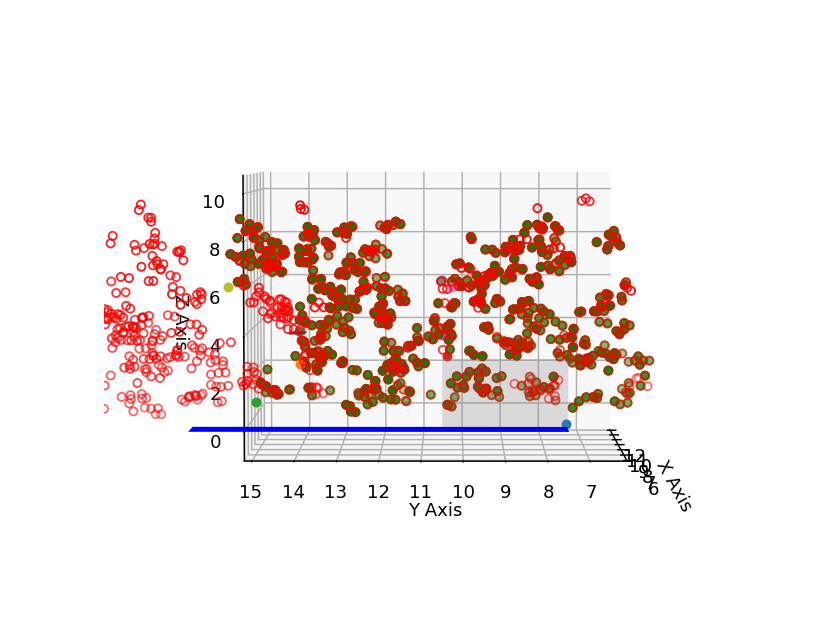

** Index grew faster than it should have? **
Index to remove: 402 in row: 2 time: 594.909999999604
current time value of fruit_removal: 594.0899999996047
** Index grew faster than it should have? **
Index to remove: 402 in row: 2 time: 595.2099999996037
current time value of fruit_removal: 594.0899999996047
** Index grew faster than it should have? **
Index to remove: 402 in row: 2 time: 595.5099999996035
current time value of fruit_removal: 594.0899999996047
** Index grew faster than it should have? **
Index to remove: 402 in row: 2 time: 595.8099999996032
current time value of fruit_removal: 594.0899999996047
** Index grew faster than it should have? **
Index to remove: 402 in row: 2 time: 596.1099999996029
current time value of fruit_removal: 594.0899999996047
** Index grew faster than it should have? **
Index to remove: 402 in row: 2 time: 596.4099999996026
current time value of fruit_removal: 594.0899999996047
** Index grew faster than it should have? **
Index to remove: 402 in ro

In [248]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row_arms):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
#                 dr.drawArmCylinder(center_y, center_z, arm_start, arm_end)
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [249]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[]
ROW 1
[]
ROW 2
[]
